<a href="https://colab.research.google.com/github/jrmirmi/ML-phenotype-pred/blob/main/Copy_logistic_regression_APOE_PET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

##import library
import gc
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/GitHub')
import numpy as np
import networkx
import csv
import pandas as pd
from tqdm import tqdm
import gzip
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from metrics import metrics
from labelling import label_ADNI
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
import itertools
from sklearn.metrics import log_loss
from sklearn.utils import shuffle

4
# https://realpython.com/logistic-regression-python/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


4

In [ ]:
# GZIP per trobar el TRAINING SET 
file_path = '/content/drive/MyDrive/PROJECT/training_set_logistic_regression_PET.csv.gz'

training_set = pd.read_csv(file_path, sep='\t', dtype=str)
training_set.rename(columns={'Unnamed: 0': 'snpid'}, inplace=True)
training_set.set_index('snpid', inplace=True)
training_set

# igual pel VALIDATION
file_path = '/content/drive/MyDrive/PROJECT/validation_set_logistic_regression_PET.csv.gz'

validation_set = pd.read_csv(file_path, sep='\t', dtype=str)
validation_set.rename(columns={'Unnamed: 0': 'snpid'}, inplace=True)
validation_set.set_index('snpid', inplace=True)
validation_set

,rs13235,rs4919862,rs8259,rs11473,rs6757,rs3752158,rs11085226,rs1683563,rs13090,rs10407968,...,rs143159382,rs35974949,rs3745902,rs147585490,rs1654410,rs1671153,rs1654419,rs1613662,rs12611091,y
snpid,,,,,,,,,,,,,,,,,,,,,
130_S_0886,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.5,1.0
128_S_2003,0.5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1.0
127_S_1427,0,0,0,0,0,0,0,0,0,0,...,0,1,0.5,0,0,0,0,0,0.5,1.0
072_S_2037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
094_S_1417,0,0.5,0,0.5,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
012_S_4545,0,0.5,0.5,0.5,0.5,0,0,0,0,0,...,0,0.5,0,0,0,0,0,0,0,0.0
128_S_4571,0,0.5,0,0,0,0,0,0,0,0,...,0,1,1,1,0.5,0,0,0,1,0.0
128_S_4607,1,0.5,0,0,0,0,0.5,0,0,0,...,0.5,0,0,1,0.5,0.5,0,0,0,0.0


In [ ]:
#modify the df to have in all the column a different SNPs and in all the rows a different patient
training_set.columns = training_set.iloc[0]
training_set = training_set['rs429358'].fillna(0)
gc.collect()

training_set


KeyError: ignored

In [ ]:
file_adnimerge = '/content/drive/MyDrive/PROJECT/output_adnimerge.csv'
adnimerge = pd.read_csv(file_adnimerge)
adnimerge = adnimerge.set_index('Unnamed: 0')

adnimerge = label_ADNI(adnimerge,'PET')

merged_df = pd.merge(df, adnimerge, left_index=True, right_index=True)
gc.collect()
merged_df



,rs429358,y
136_S_0873,0.5,1.0
130_S_0886,0,1.0
027_S_0074,0,0.0
051_S_1072,0,0.0
016_S_1117,0,1.0
...,...,...
130_S_4660,0.5,1.0
023_S_4501,0.5,1.0
070_S_4692,1,1.0
005_S_4707,0.5,1.0


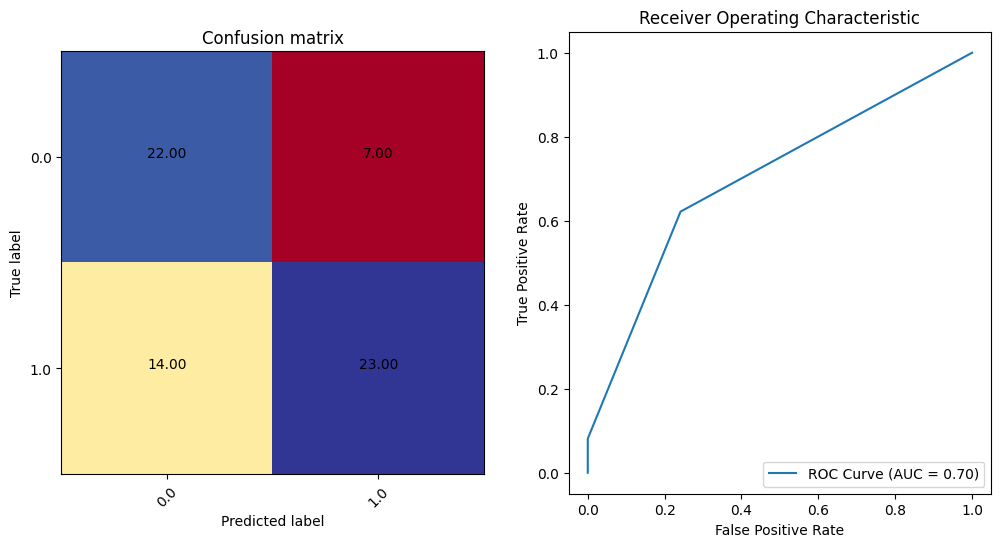

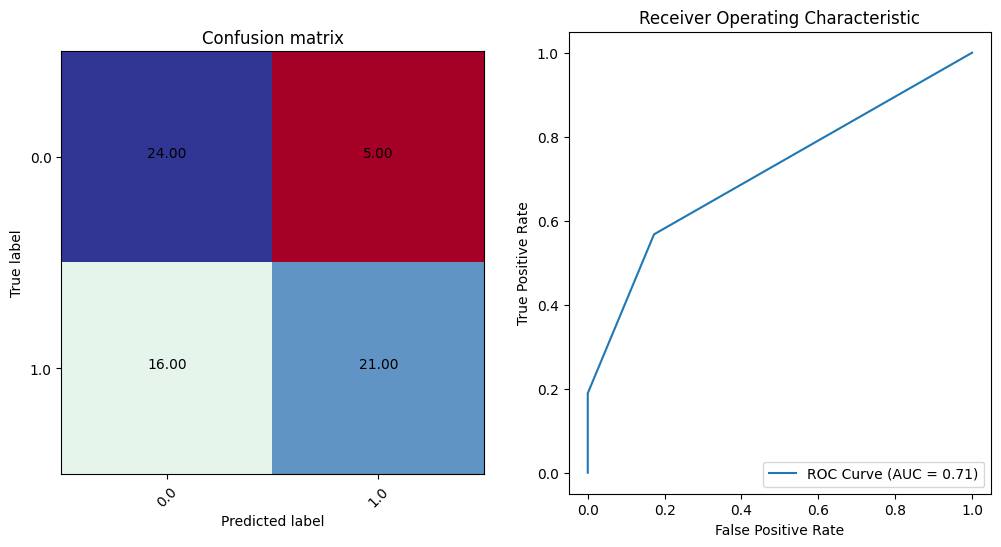

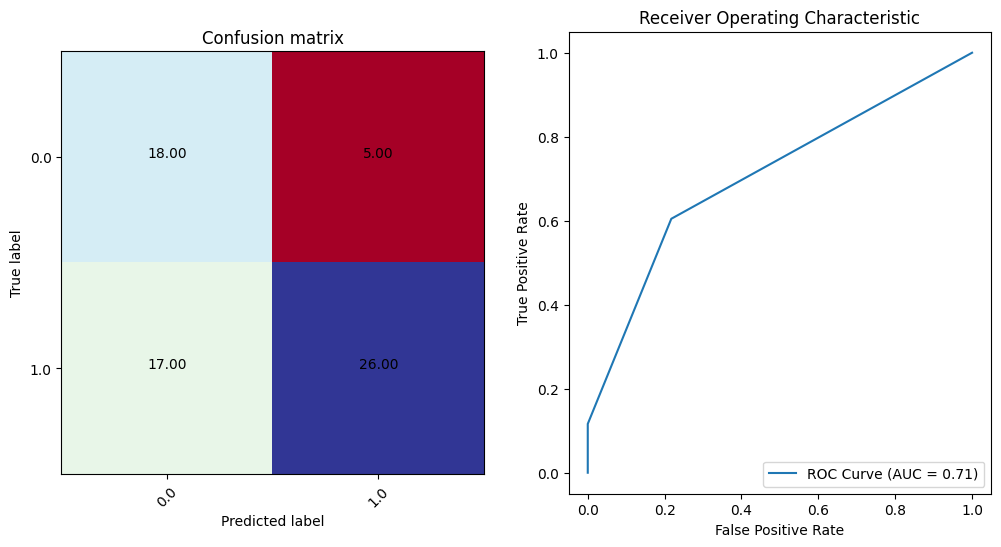

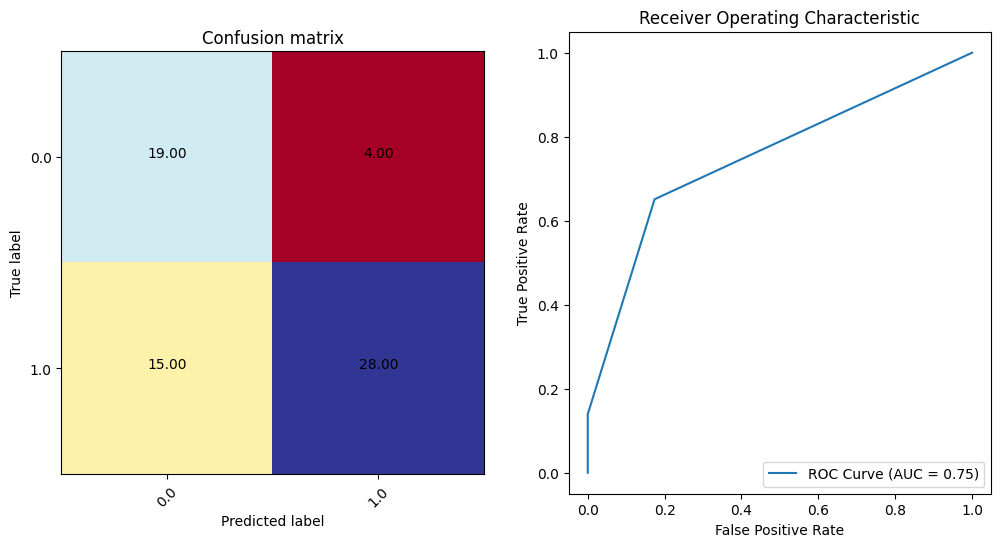

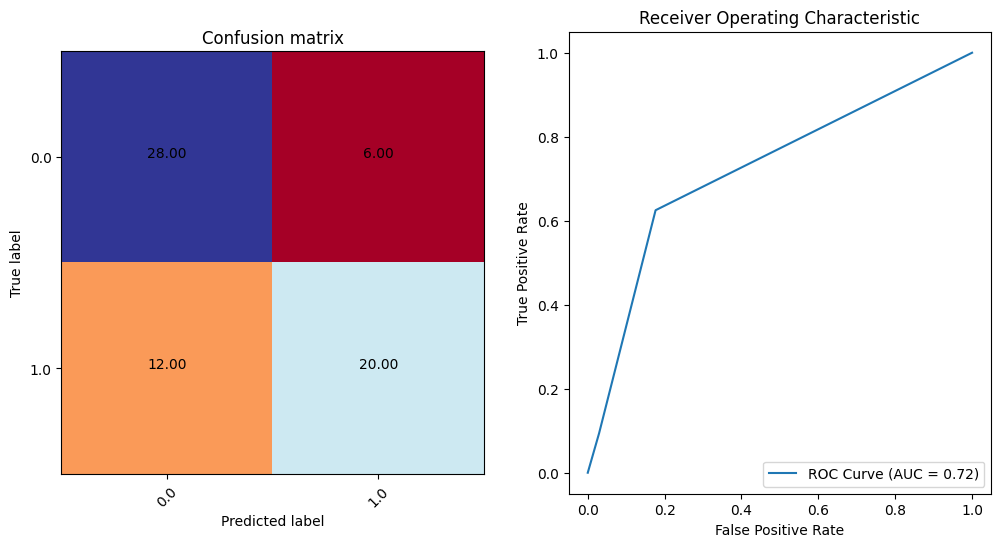

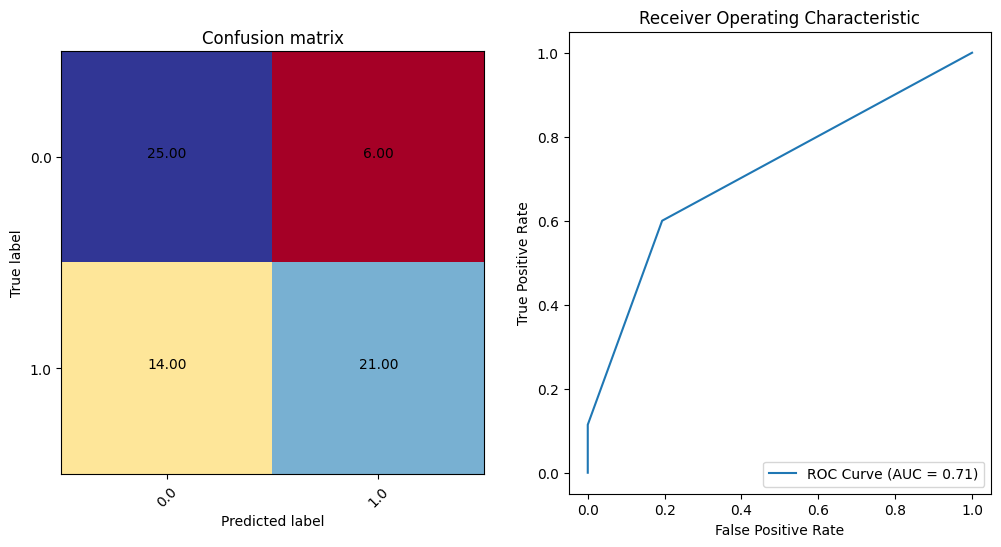

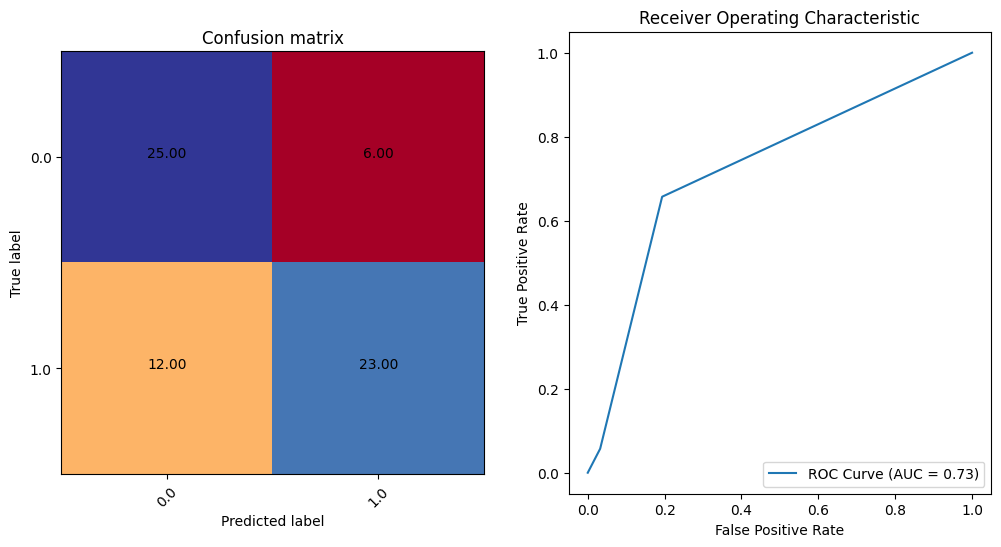

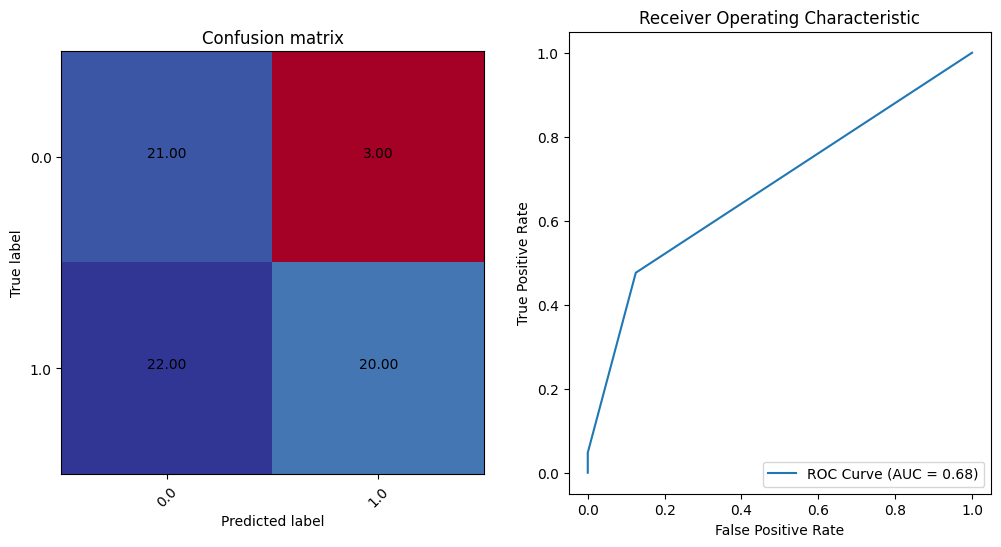

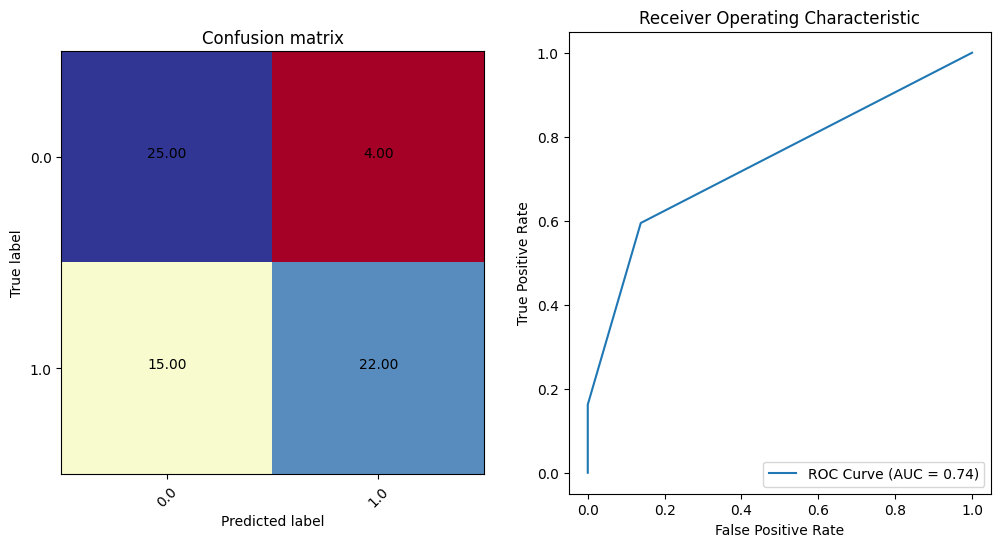

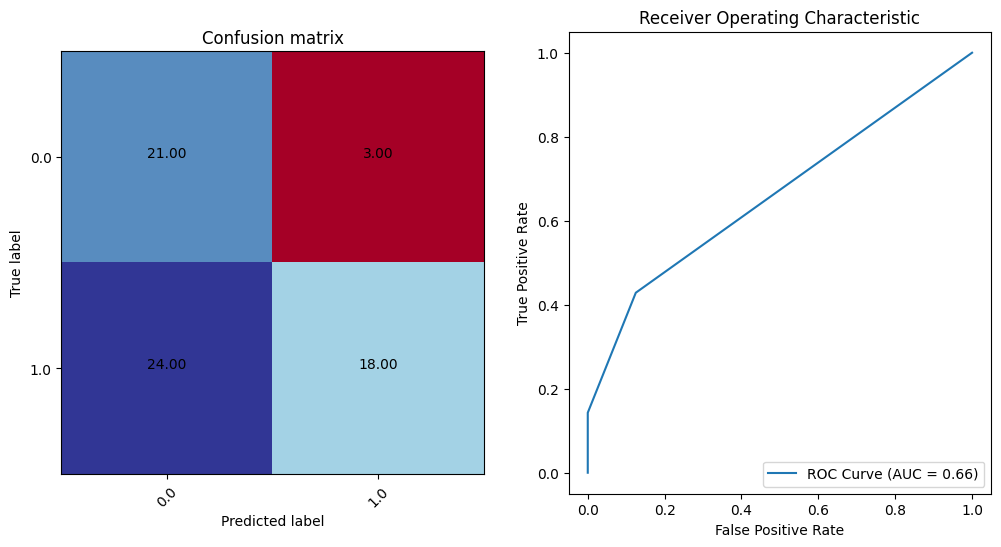

In [ ]:
# Shuffle the data
merged_df = shuffle(merged_df)

# Divide los datos en 10 conjuntos de entrenamiento y validación utilizando la validación cruzada (using cross-validation)
num_folds = 10
fold_size = len(merged_df) // num_folds
folds = []
for i in range(num_folds):
    fold = merged_df[i*fold_size:(i+1)*fold_size]
    folds.append(fold)

# Crea las listas vacías para las métricas
cm_list = []
accuracy_list = []
balanced_accuracy_list = []
precision_list = []
recall_list = []
specificity_list = []
NPV_list = []
f1_list = []
roc_auc_list = []
loss_list = []

# Bucle for para iterar 10 veces
for i in range(num_folds):
    # Divide los datos en conjuntos de entrenamiento y validación
    test_data = folds[i]
    training_data = pd.concat(folds[:i] + folds[i+1:])

    # Separa las características y la variable objetivo
    X_train = training_data.drop(columns=['y'])
    y_train = training_data['y']

    X_test = test_data.drop(columns=['y'])
    y_test = test_data['y']
    y_test = y_test.astype(float).round(1)

    model = LogisticRegression(max_iter=1000)

    # Entrena el modelo utilizando nuestros conjuntos de datos
    model.fit(X_train, y_train)

    # Realiza la predicción
    y_pred = model.predict(X_test)
    y_pred = y_pred.astype(float).round(1)
    y_proba = model.predict_proba(X_test)[:,1]

    # Calcula las métricas
    classes=['0.0', '1.0']
    cm, accuracy, balanced_accuracy, precision, recall, specificity, NPV, f1, roc_auc, thresholds = metrics(y_test, y_pred, y_proba, classes)

    # Calcula la función de pérdida
    loss = log_loss(y_test, y_proba, normalize=True, sample_weight=None, labels=[0.0, 1.0])

    # Almacena los datos en las listas
    cm_list.append(cm)
    accuracy_list.append(accuracy)
    balanced_accuracy_list.append(balanced_accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    specificity_list.append(specificity)
    NPV_list.append(NPV)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)
    loss_list.append(loss)


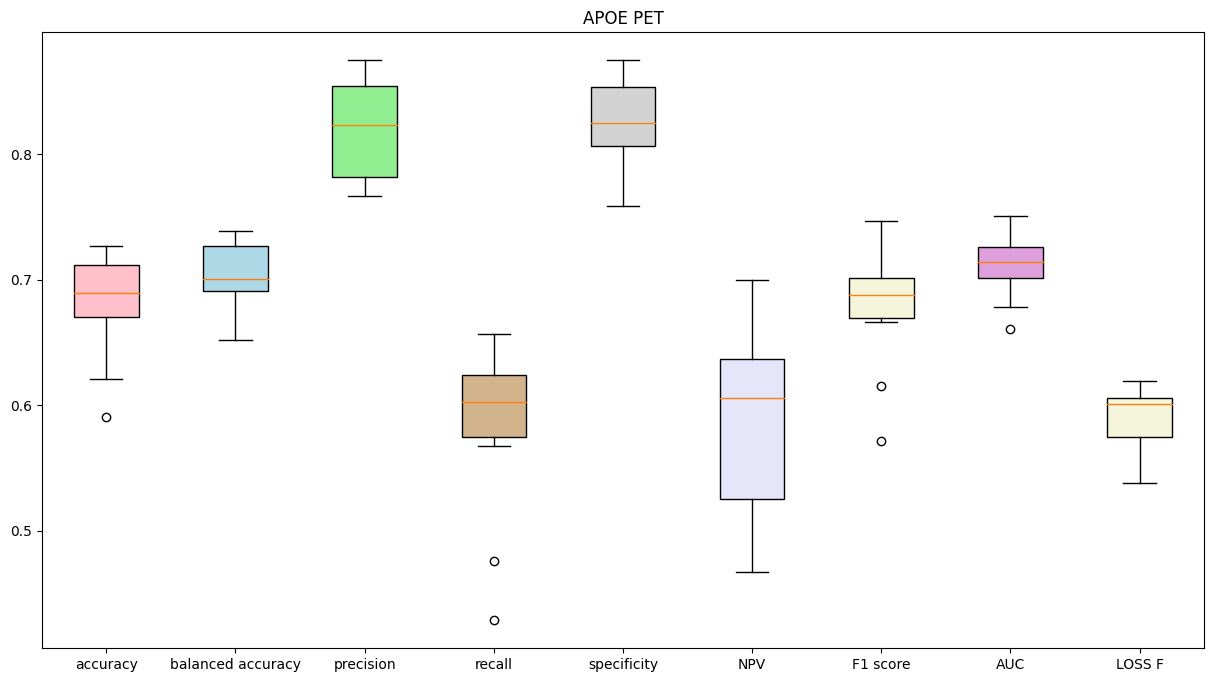

In [ ]:
# definisci una lista con le tue 8 liste di dati
metric = [accuracy_list, balanced_accuracy_list, precision_list, recall_list, specificity_list, NPV_list, f1_list, roc_auc_list, loss_list]

# definisci i nomi dei boxplot
names = ['accuracy', 'balanced accuracy', 'precision', 'recall', 'specificity', 'NPV', 'F1 score', 'AUC', 'LOSS F']

# crea la figura e gli assi
fig, ax = plt.subplots(figsize=(15, 8))

# disegna i boxplot
bp = ax.boxplot(metric, labels=names, patch_artist=True)

# imposta i colori dei boxplot
colors = ['pink', 'lightblue', 'lightgreen', 'tan', 'lightgrey', 'lavender', 'beige', 'plum', 'beige']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# imposta il titolo e le etichette degli assi
ax.set_title('APOE PET')

# mostra la figura
plt.show()

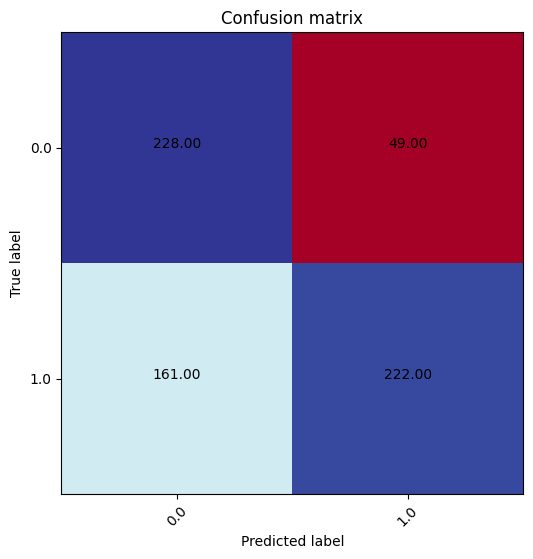

In [ ]:
cm = np.zeros((2, 2))  # Inizializzazione della matrice vuota
for i in cm_list:
    cm += i

# Creazione del grafico
fig, ax1 = plt.subplots(figsize=(12, 6))
im = ax1.imshow(cm, interpolation='nearest', cmap=plt.cm.RdYlBu)
ax1.set_title('Confusion matrix')
ax1.set_xticks(np.arange(len(classes)))
ax1.set_yticks(np.arange(len(classes)))
ax1.set_xticklabels(classes, rotation=45)
ax1.set_yticklabels(classes)
ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax1.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='black' if cm[i, j] > thresh else 'black')

plt.show()  # Mostra il grafico


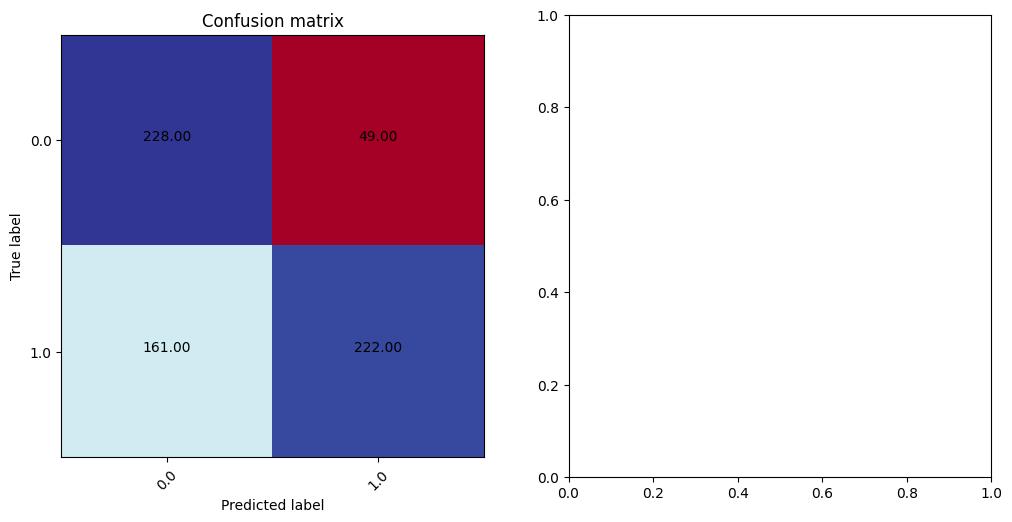

In [ ]:
cm = np.zeros((2, 2))
for i in cm_list:
  cm = cm + i
# Plot confusion matrix
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
im = ax1.imshow(cm, interpolation='nearest', cmap=plt.cm.RdYlBu)
ax1.set_title('Confusion matrix')
ax1.set_xticks(np.arange(len(classes)))
ax1.set_yticks(np.arange(len(classes)))
ax1.set_xticklabels(classes, rotation=45)
ax1.set_yticklabels(classes)
ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax1.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='black' if cm[i, j] > thresh else 'black')

In [ ]:
print(str(round(np.mean(roc_auc_list),4)) + ' +- ' + str(round(np.std(roc_auc_list),4)))

0.7114 +- 0.0256
